In [2]:
import numpy as np
import librosa
import joblib
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
MODEL_FILES = {
    'scaler': 'scaler.pkl',
    'class0': 'gmm0.pkl',
    'class1': 'gmm1.pkl'
}
WINDOW_DURATION = 1.0   # Must match training (e.g. 1.0s)
STEP_DURATION = 0.5     # Overlap (e.g. move 0.5s forward each time)
CONFIDENCE_THRESH = 2.0 # Minimum score difference to say "Event"

def load_models():
    print("Loading models...")
    scaler = joblib.load(MODEL_FILES['scaler'])
    gmm0 = joblib.load(MODEL_FILES['class0'])
    gmm1 = joblib.load(MODEL_FILES['class1'])
    return scaler, gmm0, gmm1

def test_file(file_path):
    # 1. Load Audio File
    print(f"Processing file: {file_path}")
    # Load as 16k mono (standardized)
    y, sr = librosa.load(file_path, sr=16000)
    
    scaler, gmm0, gmm1 = load_models()
    
    # Calculate window sizes in samples
    window_samples = int(WINDOW_DURATION * sr)
    step_samples = int(STEP_DURATION * sr)
    
    # 2. Slide over the file
    timestamps = []
    scores_0 = []
    scores_1 = []
    detections = []
    
    print("-" * 60)
    print(f"{'Time (s)':<10} | {'Prediction':<12} | {'Confidence':<10} | {'Status'}")
    print("-" * 60)

    # Sliding Window Loop
    for start_idx in range(0, len(y) - window_samples, step_samples):
        end_idx = start_idx + window_samples
        
        # Extract Chunk
        chunk = y[start_idx:end_idx]
        
        # Extract Features (Same as Training)
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
        # Mean across time -> (13,) vector
        feat_vector = np.mean(mfcc.T, axis=0).reshape(1, -1)
        
        # Scale
        feat_scaled = scaler.transform(feat_vector)
        
        # Score
        s0 = gmm0.score_samples(feat_scaled)[0]
        s1 = gmm1.score_samples(feat_scaled)[0]
        
        # Store for plotting later
        time_sec = start_idx / sr
        timestamps.append(time_sec)
        scores_0.append(s0)
        scores_1.append(s1)
        
        # Decision Logic
        diff = s1 - s0
        is_event = (s1 > s0) and (diff > CONFIDENCE_THRESH)
        
        if is_event:
            status = "🚨 EVENT DETECTED"
            detections.append((time_sec, diff))
            print(f"{time_sec:.2f}s      | Class 1      | {diff:.2f}       | {status}")
        else:
            # Only print every few seconds to avoid clutter, or print all if debugging
            # print(f"{time_sec:.2f}s | Class 0 | {diff:.2f}")
            pass

    # 3. Summary Report
    print("-" * 60)
    print(f"Scanning Complete. Found {len(detections)} event windows.")
    
    # 4. Optional: Visualization (Helps debug "padding" issues)
    # This plots the likelihoods over time. 
    # If Class 1 spikes up where the audio is, your training worked.
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, scores_0, label="Likelihood Class 0 (Background)", color='blue', alpha=0.6)
    plt.plot(timestamps, scores_1, label="Likelihood Class 1 (Event)", color='red', alpha=0.8)
    
    # Draw threshold area
    plt.title(f"Detection Timeline for {file_path}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Log-Likelihood Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- RUN IT ---
# Replace with a path to a real WAV/MP3 file on your computer


Processing file: Jamal.wav
Loading models...
------------------------------------------------------------
Time (s)   | Prediction   | Confidence | Status
------------------------------------------------------------


c:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


------------------------------------------------------------
Scanning Complete. Found 0 event windows.


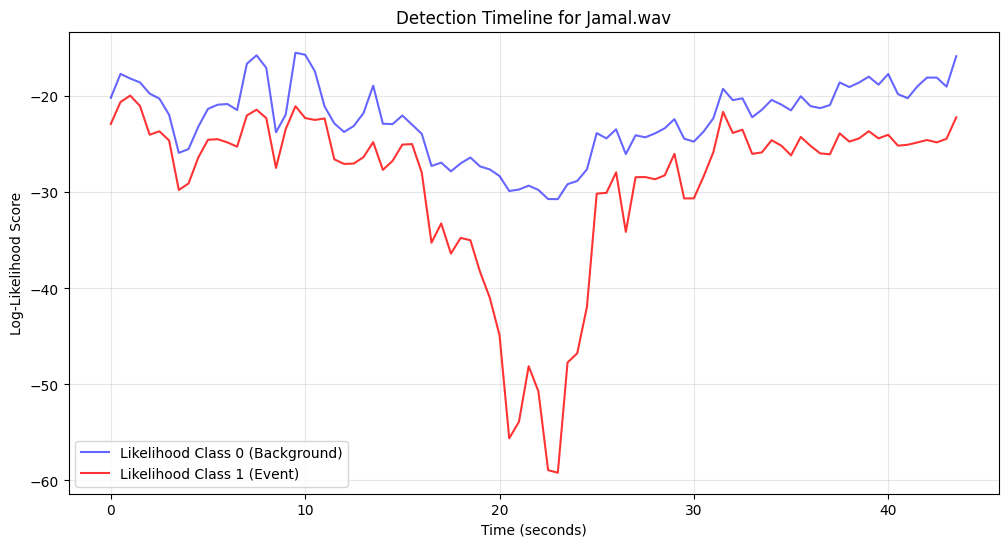

In [3]:
test_file("Jamal.wav")

Loading models...


c:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading train_class1_sample0.wav...
Scanning...


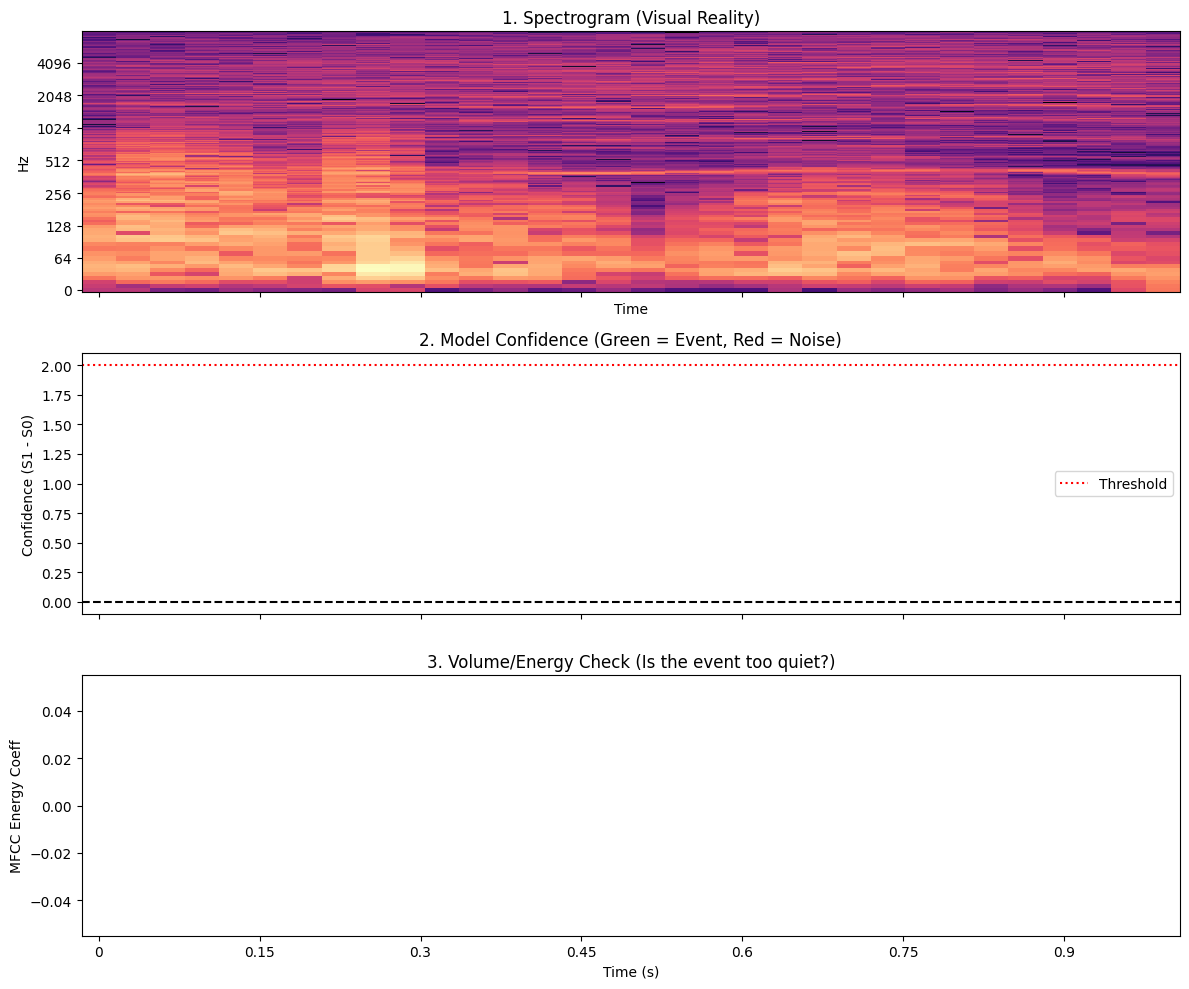

In [1]:
import numpy as np
import librosa
import librosa.display
import joblib
import matplotlib.pyplot as plt

# --- CONFIG ---
TEST_FILE = "train_class1_sample0.wav"  # <--- Change this to your file
MODEL_FILES = {'scaler': 'scaler.pkl', 'class0': 'gmm0.pkl', 'class1': 'gmm1.pkl'}
WINDOW_LEN = 1.0  # seconds
STEP_LEN = 0.1    # Step size (smaller = higher resolution for debugging)

def analyze_failure(file_path):
    # 1. Load Models
    print("Loading models...")
    scaler = joblib.load(MODEL_FILES['scaler'])
    gmm0 = joblib.load(MODEL_FILES['class0'])
    gmm1 = joblib.load(MODEL_FILES['class1'])

    # 2. Load Audio
    print(f"Loading {file_path}...")
    y, sr = librosa.load(file_path, sr=16000)
    
    # 3. Scan the file
    timestamps = []
    scores_diff = []  # Class 1 - Class 0 (Confidence)
    mfcc_energy = []  # To check volume issues
    
    # Calculate window parameters
    n_window = int(WINDOW_LEN * sr)
    n_step = int(STEP_LEN * sr)
    
    print("Scanning...")
    for i in range(0, len(y) - n_window, n_step):
        chunk = y[i : i + n_window]
        
        # MFCC (The Model's "Eyes")
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
        mfcc_vec = np.mean(mfcc.T, axis=0).reshape(1, -1)
        
        # Scaling
        feat_scaled = scaler.transform(mfcc_vec)
        
        # Scores
        s0 = gmm0.score_samples(feat_scaled)[0]
        s1 = gmm1.score_samples(feat_scaled)[0]
        
        timestamps.append(i / sr)
        scores_diff.append(s1 - s0)
        mfcc_energy.append(np.mean(mfcc[0])) # 0th Coeff is roughly Volume
        
    # --- PLOTTING ---
    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: The Raw Spectrogram (What the ear hears)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax[0])
    ax[0].set_title("1. Spectrogram (Visual Reality)")
    
    # Plot 2: Model Confidence (What the brain thinks)
    ax[1].plot(timestamps, scores_diff, color='purple', linewidth=2)
    ax[1].axhline(0, color='black', linestyle='--') # The "Indecision" line
    ax[1].axhline(2.0, color='red', linestyle=':', label='Threshold') # Your threshold
    ax[1].fill_between(timestamps, scores_diff, 0, where=(np.array(scores_diff)>0), color='green', alpha=0.3)
    ax[1].fill_between(timestamps, scores_diff, 0, where=(np.array(scores_diff)<0), color='red', alpha=0.3)
    ax[1].set_ylabel("Confidence (S1 - S0)")
    ax[1].set_title("2. Model Confidence (Green = Event, Red = Noise)")
    ax[1].legend()

    # Plot 3: Energy / Volume (0th MFCC Coefficient)
    ax[2].plot(timestamps, mfcc_energy, color='orange')
    ax[2].set_ylabel("MFCC Energy Coeff")
    ax[2].set_xlabel("Time (s)")
    ax[2].set_title("3. Volume/Energy Check (Is the event too quiet?)")
    
    plt.tight_layout()
    plt.show()

# Run it
analyze_failure(TEST_FILE)

In [9]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import io
from datasets import load_dataset

# --- CONFIGURATION ---
DATASET_NAME = "geronimobasso/drone-audio-detection-samples" # Replace with your dataset
SAMPLE_RATE = 16000
WINDOW_SAMPLES = 16000 # 1.0 Second
SAMPLES_TO_INSPECT = 3 # How many files per class to save

def enforce_window_size(audio, target_len):
    """ Same logic as your training script """
    curr_len = len(audio)
    if curr_len == target_len:
        return [audio]
    elif curr_len > target_len:
        # Just take the first chunk for inspection
        return [audio[:target_len]]
    else:
        # Pad center
        pad_total = target_len - curr_len
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        return [np.pad(audio, (pad_left, pad_right), mode='constant')]

def inspect_training_data():
    print(f"Fetching samples from {DATASET_NAME}...")
    
    # Load streaming (no huge download)
    ds = load_dataset(DATASET_NAME, split="train", streaming=True)
    
    counts = {0: 0, 1: 0}
    
    plt.figure(figsize=(15, 8))
    plot_idx = 1
    
    for i, item in enumerate(ds):
        label = item['label']
        if counts[label] >= SAMPLES_TO_INSPECT:
            if counts[0] >= SAMPLES_TO_INSPECT and counts[1] >= SAMPLES_TO_INSPECT:
                break
            continue

        try:
            # 1. Decode
            audio_bytes = item['audio']['bytes']
            audio, _ = librosa.load(io.BytesIO(audio_bytes), sr=SAMPLE_RATE)
            
            # 2. Process (Simulate Training Prep)
            # We take the first valid chunk generated by the preprocessor
            processed_chunks = enforce_window_size(audio, WINDOW_SAMPLES)
            final_audio = processed_chunks[0]
            
            # 3. Save to Disk
            filename = f"train_class{label}_sample{counts[label]}.wav"
            sf.write(filename, final_audio, SAMPLE_RATE)
            print(f"Saved {filename}")
            
            # 4. Plot Spectrogram
            ax = plt.subplot(2, SAMPLES_TO_INSPECT, plot_idx)
            if label == 1: 
                plot_idx += 1 # Move to next slot
            else:
                # Plot Class 0 on top row, Class 1 on bottom row logic requires manual index handling
                # Let's simplify: Just plot them sequentially
                pass

            # Better Plot Layout logic:
            # Row 1: Class 0, Row 2: Class 1
            if label == 0:
                ax = plt.subplot(2, SAMPLES_TO_INSPECT, counts[label] + 1)
                title = f"Class 0 (Background) #{counts[label]}"
            else:
                ax = plt.subplot(2, SAMPLES_TO_INSPECT, SAMPLES_TO_INSPECT + counts[label] + 1)
                title = f"Class 1 (Event) #{counts[label]}"
            
            D = librosa.amplitude_to_db(np.abs(librosa.stft(final_audio)), ref=np.max)
            librosa.display.specshow(D, sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax)
            ax.set_title(title)
            
            counts[label] += 1
            
        except Exception as e:
            print(f"Skipped error: {e}")
            continue

    plt.tight_layout()
    plt.show()
    print("\n✅ Inspection Complete. Check the .wav files in your folder.")

inspect_training_data()

c:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching samples from geronimobasso/drone-audio-detection-samples...


RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6, 7, and 8.
          2. The PyTorch version (2.9.1+cpu) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 8: Could not load this library: C:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\torchcodec\libtorchcodec_core8.dll
FFmpeg version 7: Could not load this library: C:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\torchcodec\libtorchcodec_core7.dll
FFmpeg version 6: Could not load this library: C:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\torchcodec\libtorchcodec_core6.dll
FFmpeg version 5: Could not load this library: C:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\torchcodec\libtorchcodec_core5.dll
FFmpeg version 4: Could not load this library: C:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\torchcodec\libtorchcodec_core4.dll
[end of libtorchcodec loading traceback].

<Figure size 1500x800 with 0 Axes>